#### 3.	Data Import and Cleaning
* <b> Import the necessary libraries: pandas, numpy, matplotlib, seaborn, etc. </b>  
* <b> Load the dataset into a pandas DataFrame.</b>  
* <b> Perform initial data inspection: check the shape of the data, data types, and summary statistics. </b>
* <b> Identify and handle missing values. Decide whether to drop, fill, or interpolate missing data based on the context. </b>  
* <b> Detect and remove duplicate rows if any.</b>
* <b> Convert data types if necessary (e.g., dates should be in datetime format). </b>  

In [97]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
print ('Sucess')

Sucess


##### Data set description 
* area_type: The type of the house area feature 'total_sqft' specifies.
* availability: The availability date or availability status of the property.
* location: The locality of the property in Bengaluru city.
* size: The size of the housing property in BHK (or Bedrooms etc.,).
* society: The name of the Apartment. This name is encrypted for confidentiality.
* total_sqft: The 'area_type' area of the property.
* bath: Number of bathrooms available in the house.
* balcony: Number of balcony/balconies the house has.
* price: Price of the housing property in Lakhs. (target feature)

In [ ]:
#Loading dataset
house_price = pd.read_csv('bengaluru_house_prices.csv')
house_price.head(2)

In [ ]:
house_price.head(2)

In [ ]:
#Perform initial data inspection: check the shape of the data, data types, and summary statistics.
print('shape-->', house_price.shape)
numeric_columns = house_price.select_dtypes(include = np.number).columns.to_list()
categorical_columns = house_price.select_dtypes(exclude = np.number).columns.to_list()

numeric_columns,categorical_columns

In [ ]:
#house_price.describe()
for cols in categorical_columns:
    print (cols, '-->', house_price[cols].unique())

In [102]:
house_price_copy = house_price.copy()

### Identify and handle missing values. Decide whether to drop, fill, or interpolate missing data based on the context.

In [ ]:
house_price_copy.isnull().sum()
house_price_copy.isna().sum()

## Data Transformation

### <b> Dropping society column as it does not add any values </b>

In [104]:
house_price_copy = house_price_copy.drop(columns = ['society'])

#### <b> Remove the rows with no information in Size, alternatively a complex total_sqft based extimation can be used </b>

In [105]:
house_price_copy = house_price_copy.dropna(subset = ['size'])

In [ ]:
house_price_copy.head(2)
#house_price_copy['availability_refined'].unique()

#### <b> Transforming Availibility Column </b>
* <b> availability_refined </b> - Where ever date is there upgrade it to 'Under Construction' </b>
* <b> availibility_due </b> - Also create new column availibility_due for Under Construction due month  </b>

In [107]:
house_price_copy['availability'].unique()

def calculate_availibility(values):
    if values != 'Ready To Move':
        day,month = values.split('-')
        value1 = 'Under Construction'
    else:
        month = 'NA'
        value1 = 'Ready To Move'
    return value1, month

In [108]:
house_price_copy[['availability_refined', 'availibility_due']] = house_price_copy['availability'].apply(lambda x: pd.Series(calculate_availibility(x)))

In [109]:
#Now lets remove availaibility columns
house_price_copy= house_price_copy.drop(columns= ['availability'])

### Analyze Size and accordingly check the bathroom and balcony size

In [110]:
house_price_copy['size'].unique()
house_price_copy['size_bhk'] = house_price_copy['size'].str.split().str[0].astype(int)

In [111]:
#Dropping the size column
house_price_copy = house_price_copy.drop(columns = ['size'])

In [ ]:
house_price_copy['total_sqft_number'] = pd.to_numeric(house_price_copy['total_sqft_number'], errors='coerce')
house_price_copy['scale'] = pd.to_numeric(house_price_copy['scale'], errors='coerce')
house_price_copy = house_price_copy.drop(columns = ['Unnamed: 0.1','Unnamed: 0'])

### Location Transformation
#### As per analysis , there are too many location and it is not possible to group them to a common parameter, hence the best solution is to drop them

In [ ]:
house_price_copy.groupby(by = 'location')['price'].agg(['mean','std'])

,mean,std
location,,
Anekal,16.000000,NaN
Banaswadi,35.000000,NaN
Basavangudi,50.000000,NaN
Bhoganhalli,22.890000,NaN
Devarabeesana Halli,124.833333,42.663411
...,...,...
t.c palya,160.000000,NaN
tc.palya,60.750000,12.841988
vinayakanagar,200.000000,NaN


In [ ]:
house_price_copy = house_price_copy.drop(columns = ['location'])

### Analyzing total sqfit, following transformation is done
* create  Scale variable to hold the scale for converting sq.Meter, sq.Yards, Acres
* Run two step tranformations to
* * Take average for ranges 1100-1200
* * remove words e.g. sq.meter, sq.yards,acres
* multiply scale to values to bring them to common unit sq.ft

In [ ]:
def  calculate_sqftscale(values):
    if 'Yards' in values:
        scale_tofit = 9
    elif 'Meter' in values:
        scale_tofit = 10.8
    elif 'Acres' in values:
        scale_tofit = 43560
    else:
        scale_tofit = 1
    return scale_tofit

In [ ]:
house_price_copy['scale']= house_price_copy['total_sqft'].apply(calculate_sqftscale)

In [ ]:
#Now extarct only numeric from the sq.meter, sq.wards
import re

In [ ]:
# Function to calculate the mean from the range string
def calculate_total_sqft_transform(value):
    if ' - ' in value:
        # Split the string by ' - ' and calculate the mean of the two numbers
        start, end = value.split(' - ')
        return (float(start) + float(end)) / 2
    else:
        # Return the value as unless it has units in squads 'sq.Yards'
        value_num = re.findall(r'\d+', value)[0]
        return (value_num)

In [ ]:
# Create a new column 'total_sqft_number' by applying the function
house_price_copy['total_sqft_number'] = house_price_copy['total_sqft'].apply(calculate_total_sqft_transform)   

In [ ]:
columns_to_drop = [col for col in ['Unnamed: 0.1', 'Unnamed: 0'] if col in house_price_copy.columns]
house_price_copy = house_price_copy.drop(columns=columns_to_drop)

In [ ]:
# Dropping columns 
house_price_copy = house_price_copy.drop(columns = ['total_sqft','total_sqft_number'])

## Save and BackUp

In [ ]:
#Backing up by exporting the data
#house_price_copy.to_csv('House Price Cleaned temp.csv', index = False)

In [ ]:
house_price_copy = pd.read_csv('House Price Cleaned.xls')

In [ ]:
#house_price_copy[house_price_copy['scale']== 9]
house_price_copy.head(3)

,area_type,bath,balcony,price,availability_refined,availibility_due,size_bhk,scale,total_sqft_refined
0,Super built-up Area,2.0,1.0,39.07,Under Construction,Dec,2,1.0,1056.0
1,Plot Area,5.0,3.0,120.00,Ready To Move,Ready,4,1.0,2600.0
2,Built-up Area,2.0,3.0,62.00,Ready To Move,Ready,3,1.0,1440.0


In [ ]:
##house_price_copy['availibility_due'] = house_price_copy['availibility_due'].fillna('Ready')

## Exploratory Data Analysis (EDA)

### Descriptive Statistics:
* Provide summary statistics for numerical columns (mean, median, standard deviation, etc.).  
* Provide summary statistics for categorical columns (frequency counts, unique values, etc.).  

In [115]:
numeric_col = house_price_copy.select_dtypes(include = np.number).columns.to_list()
categorical_col = house_price_copy.select_dtypes(exclude = np.number).columns.to_list()

In [ ]:
house_price_copy[numeric_col].describe()

### Analysis insights 
1) 67% of properties are belong to Super built-up  Area
2) 79.5% of properties are Ready to Move in
3) For the under construction properties around 50% are getting handed over in Apr , May and  Dec 

In [ ]:
for col1 in categorical_col:
    print (house_price_copy[col1].value_counts(normalize = True) * 100)
    print ('\n')

## Data Visualization:
*	Create histograms or density plots for numerical features to understand their distributions.
*	Create bar plots for categorical features to visualize the frequency of categories.
*	Use box plots to identify outliers and understand the spread of the data.
*	Create scatter plots to explore relationships between numerical features.
*	Use heatmaps to visualize correlations between numerical features.


In [ ]:
categorical_col

['area_type', 'availability_refined', 'availibility_due']

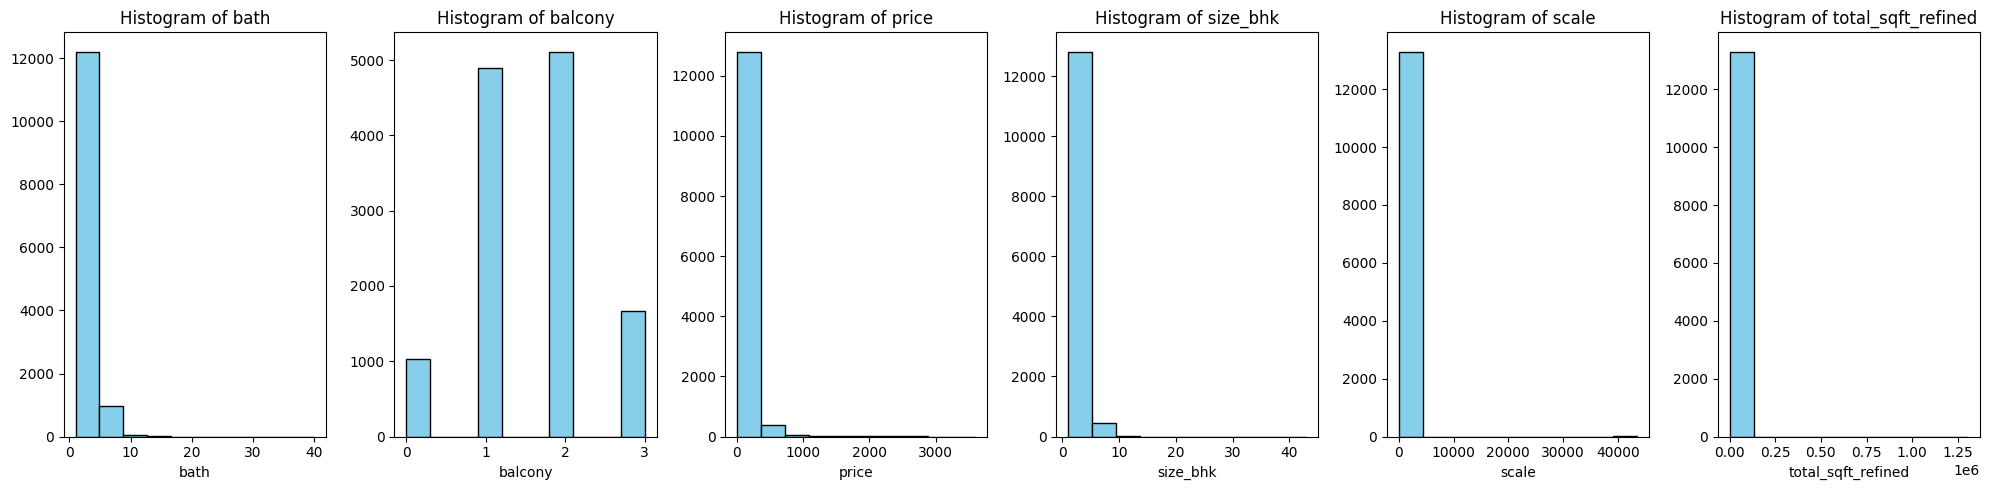

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_col), figsize=(20, 5))
# Plot histograms for each numerical column
for i, ncol in enumerate(numeric_col):
    
    axes[i].hist(house_price_copy[ncol], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {ncol}')
    axes[i].set_xlabel(ncol)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

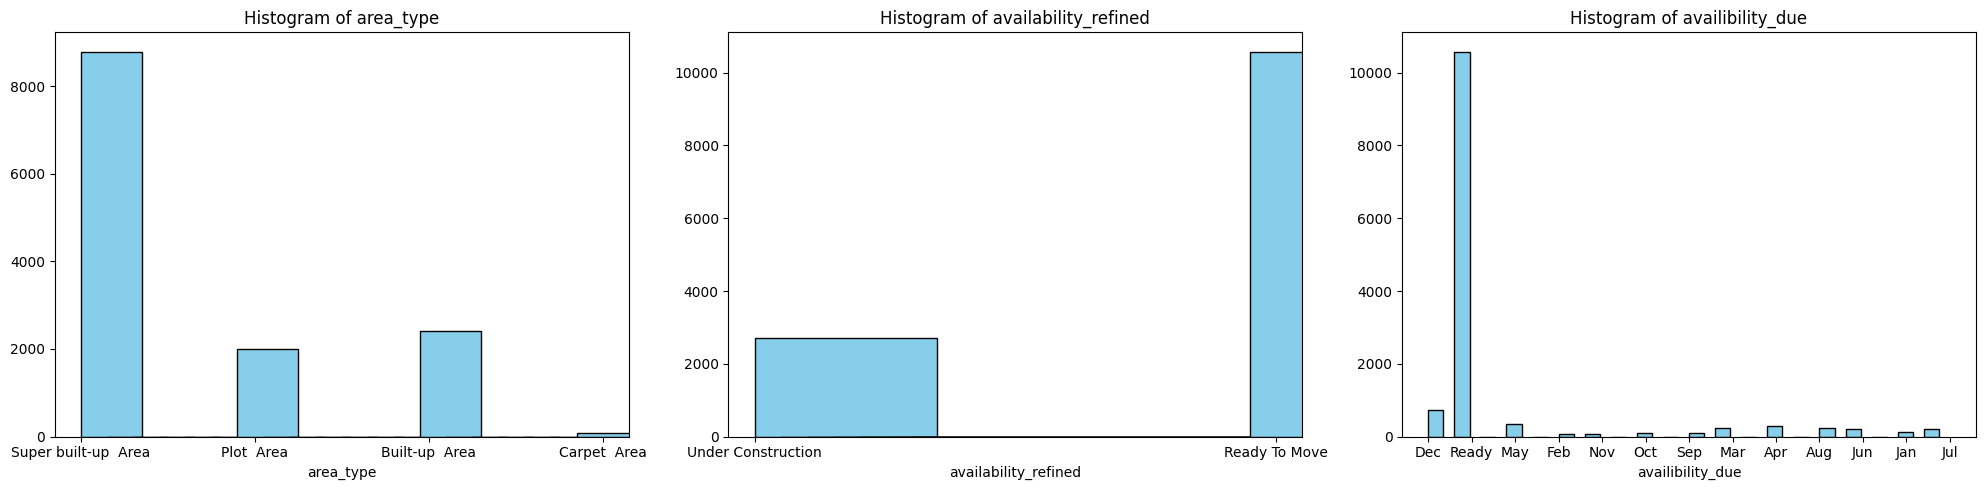

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_col), figsize=(20,5))
# Plot histograms for each numerical column
for i, ccol in enumerate(categorical_col):
    axes[i].hist(house_price_copy[ccol], bins=20, color='skyblue', edgecolor='black',width = 0.35)
    axes[i].set_title(f'Histogram of {ccol}')
    axes[i].set_xlabel(ccol)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


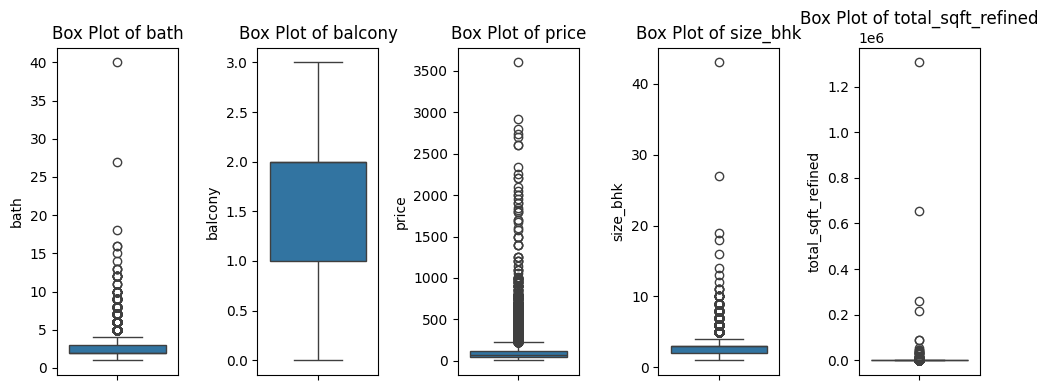

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(10, 4))  # 1 row, 5 columns

# List of column names to plot
columns = ['bath', 'balcony', 'price', 'size_bhk', 'total_sqft_refined']

# Plot each box plot in the respective subplot
for i, col in enumerate(columns):
    sns.boxplot(data=house_price_copy, y=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')

# Adjust the layout to make sure there is no overlap
plt.tight_layout()

# Show the plot
plt.show()

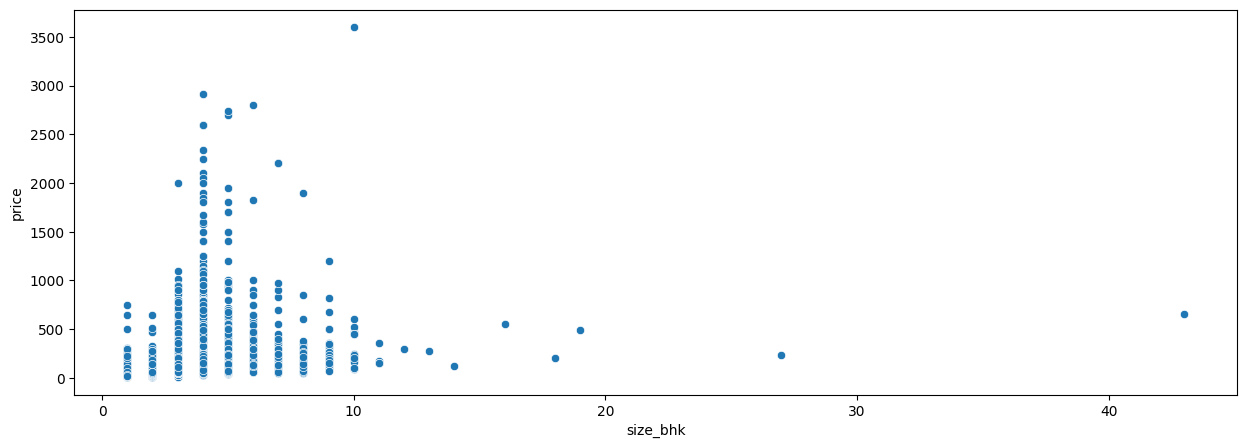

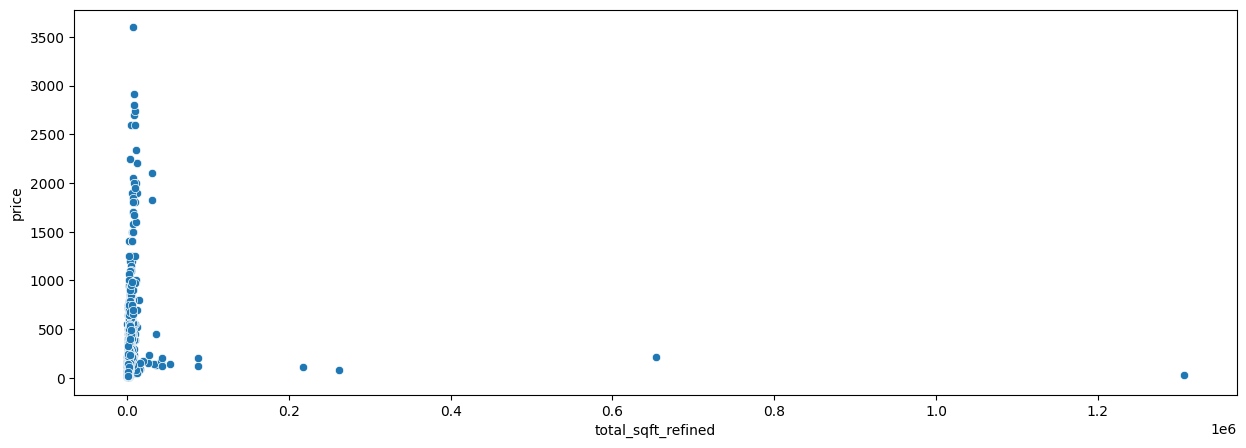

In [ ]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = house_price_copy['size_bhk'], y = house_price_copy['price'])
plt.show()

plt.figure(figsize = (15,5))
sns.scatterplot(x = house_price_copy['total_sqft_refined'], y = house_price_copy['price'])
plt.show()

<Axes: >

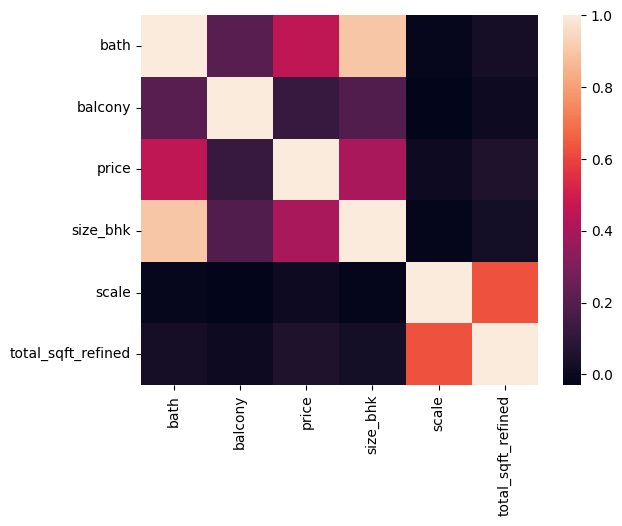

In [ ]:
#Use heatmaps to visualize correlations between numerical features.
corr_mat = house_price_copy[numeric_col].corr()
sns.heatmap(corr_mat)

####	Group Analysis:
* Perform group-by operations to aggregate data based on categorical features.


In [ ]:
house_price_copy.groupby(by = ['area_type'])['price'].mean()

area_type
Built-up  Area          104.285498
Carpet  Area             89.502356
Plot  Area              209.368148
Super built-up  Area     92.971757
Name: price, dtype: float64

In [ ]:
house_price_copy.groupby(by = ['availability_refined'])['price'].mean()

availability_refined
Ready To Move         115.179137
Under Construction    102.490248
Name: price, dtype: float64

In [ ]:
house_price_copy.groupby(by = [ 'availibility_due'])['price'].mean()

availibility_due
Apr     99.505705
Aug     70.045221
Dec     95.154464
Feb    123.664533
Jan    194.345873
Jul    107.537767
Jun     89.660650
Mar    119.812744
May    106.666627
NA     115.179137
Nov     71.347911
Oct     84.513626
Sep    115.088793
Name: price, dtype: float64